# Fraud Detection in Internship Applications

---

### Objective of the Project
"""
The objective of this project is to identify anomalies in internship applications to prevent fake or fraudulent entries. 
We aim to analyze patterns such as duplicate entries, rapid multiple submissions, and inconsistent data. 
Using machine learning techniques like Isolation Forest and K-Means Clustering, we detect suspicious behavior and implement alerts to flag such applications.
"""

---

## Introduction

### Background and Motivation
"""
Fraudulent internship applications can undermine the recruitment process, wasting time and resources. 
With the increase in online application submissions, automated methods to detect suspicious applications are essential.
"""

### Problem Statement
"""
How can we effectively identify fake or suspicious internship applications from large datasets using anomaly detection techniques?
"""

### Importance of Fraud Detection in Internship Applications
"""
Detecting fraudulent applications helps maintain the integrity of the selection process, ensures genuine candidates are shortlisted, and improves overall recruitment efficiency.
"""

---

## Dataset Description

### Overview of Dataset
"""
The dataset contains application records from internship applicants, including personal details, submission times, and other metadata.
"""

### Columns and Their Description
columns = [
    "application_id", "applicant_name", "email", "phone_number", "university",
    "degree", "cgpa", "submission_time", "ip_address", "resume_quality_score",
    "application_source", "previous_applications"
]

## Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import datetime

## Data Generation (Synthetic Dataset)

In [4]:
from faker import Faker
import random

fake = Faker()
Faker.seed(0)
np.random.seed(0)

n = 10000

universities = ['Harvard', 'MIT', 'Stanford', 'LUMS', 'FAST', 'NUST']
degrees = ['BSc CS', 'BS IT', 'BE SE', 'BBA', 'BS AI']
sources = ['Mobile', 'Desktop']

submission_times = [fake.date_time_between(start_date='-30d', end_date='now') for _ in range(n)]
data = {
    'application_id': [i+1 for i in range(n)],
    'applicant_name': [fake.name() for _ in range(n)],
    'email': [fake.email() for _ in range(n)],
    'phone_number': [fake.phone_number() for _ in range(n)],
    'university': [random.choice(universities) for _ in range(n)],
    'degree': [random.choice(degrees) for _ in range(n)],
    'cgpa': [round(random.uniform(2.0, 4.0), 2) for _ in range(n)],
    'submission_time': submission_times,
    'ip_address': [fake.ipv4_public() for _ in range(n)],
    'resume_quality_score': [random.randint(40, 100) for _ in range(n)],
    'application_source': [random.choice(sources) for _ in range(n)],
    'previous_applications': [random.randint(0, 5) for _ in range(n)],
}

df = pd.DataFrame(data)
df.head()

,application_id,applicant_name,email,phone_number,university,degree,cgpa,submission_time,ip_address,resume_quality_score,application_source,previous_applications
0,1,Kevin Johnson,miranda66@example.net,(702)327-1481x38254,MIT,BS AI,2.11,2025-05-08 23:54:20,177.141.217.209,96,Mobile,3
1,2,Victoria Garcia,clarkraymond@example.org,001-434-251-3282x82573,FAST,BSc CS,2.35,2025-05-10 17:03:50,162.54.14.205,58,Desktop,3
2,3,Thomas Pace,claudia71@example.net,3817302531,Harvard,BS IT,3.75,2025-04-22 06:13:48,209.103.2.201,90,Desktop,2
3,4,Gregory Guzman,thompsonmichelle@example.net,930-710-0007x1060,FAST,BS IT,2.32,2025-05-02 20:43:20,1.58.186.137,66,Desktop,0
4,5,Amanda Reid,hollydelgado@example.net,001-958-933-5749x351,NUST,BBA,3.71,2025-05-15 02:44:26,68.194.157.0,92,Desktop,2


## Data Cleaning and Preprocessing

### Convert submission_time to datetime

In [23]:
if not np.issubdtype(df['submission_time'].dtype, np.datetime64):
    df['submission_time'] = pd.to_datetime(df['submission_time'])

### Extract features from timestamp


In [24]:
df['submission_hour'] = df['submission_time'].dt.hour
df['submission_day'] = df['submission_time'].dt.dayofweek
df['is_weekend'] = df['submission_day'].apply(lambda x: 1 if x >= 5 else 0)

### Check for missing values

In [25]:
df.isnull().sum()

application_id           0
applicant_name           0
email                    0
phone_number             0
university               0
degree                   0
cgpa                     0
submission_time          0
ip_address               0
resume_quality_score     0
application_source       0
previous_applications    0
submission_hour          0
submission_day           0
is_weekend               0
submissions_per_ip       0
is_repeated_applicant    0
anomaly_iforest          0
kmeans_cluster           0
anomaly_kmeans           0
final_anomaly            0
alert                    0
pca1                     0
pca2                     0
email_dup                0
phone_dup                0
resume_cgpa_ratio        0
ip_submission_count      0
dtype: int64

## Exploratory Data Analysis (EDA)

### Check duplicate emails and IPs

In [26]:
print("Duplicate emails:", df['email'].duplicated().sum())
print("Duplicate IPs:", df['ip_address'].duplicated().sum())

Duplicate emails: 210
Duplicate IPs: 0


### Distribution of CGPA

C:\Users\Other User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


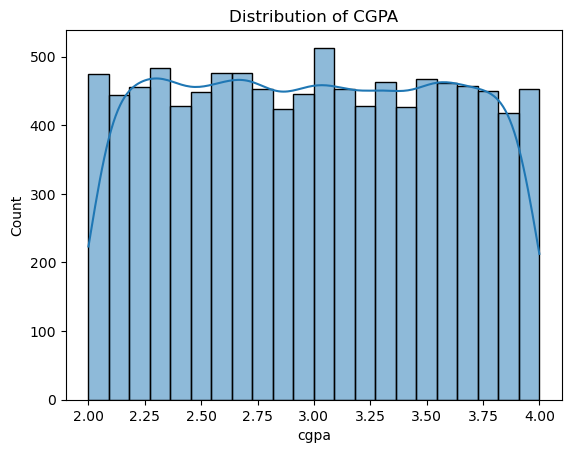

In [27]:
sns.histplot(df['cgpa'], kde=True)
plt.title('Distribution of CGPA')
plt.show()

### Application Source Distribution

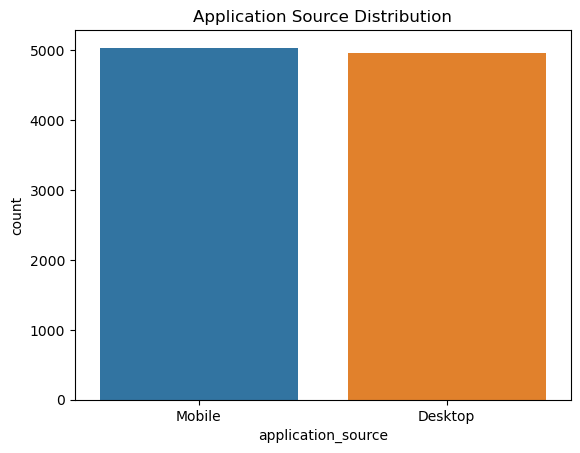

In [28]:
sns.countplot(x='application_source', data=df)
plt.title('Application Source Distribution')
plt.show()

### Resume Quality Score Distribution

C:\Users\Other User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


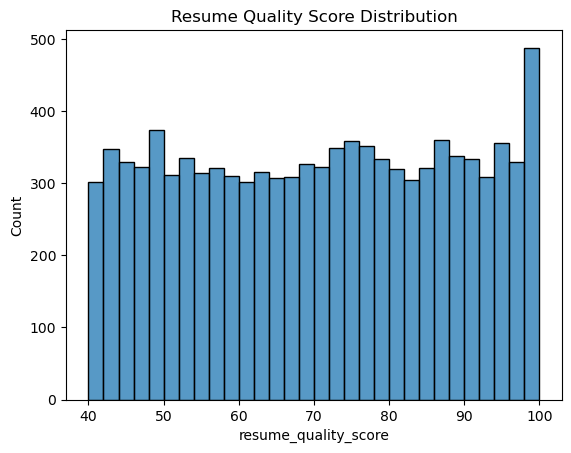

In [29]:
sns.histplot(df['resume_quality_score'], bins=30)
plt.title('Resume Quality Score Distribution')
plt.show()

## Feature Engineering

### Create features like submission_per_hour and suspicious IP

In [30]:
df['submissions_per_ip'] = df.groupby('ip_address')['ip_address'].transform('count')
df['is_repeated_applicant'] = df['previous_applications'].apply(lambda x: 1 if x > 2 else 0)

In [31]:
df['email_dup'] = df.duplicated('email', keep=False).astype(int)
df['phone_dup'] = df.duplicated('phone_number', keep=False).astype(int)
df['resume_cgpa_ratio'] = df['resume_quality_score'] / (df['cgpa'] + 1e-6)

### Count submissions per IP


In [32]:
ip_counts = df['ip_address'].value_counts()
df['ip_submission_count'] = df['ip_address'].map(ip_counts)

## Data Scaling

### Normalize numeric data before feeding into models

In [33]:
features = ['cgpa', 'resume_quality_score', 'submission_hour', 'submission_day', 'is_weekend',
            'submissions_per_ip', 'previous_applications']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

## Anomaly Detection with Isolation Forest

In [34]:
iso_model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
df['anomaly_iforest'] = iso_model.fit_predict(df_scaled)
df['anomaly_iforest'] = df['anomaly_iforest'].apply(lambda x: 1 if x == -1 else 0)

##  Anomaly Detection with K-Means

In [35]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)
df['kmeans_cluster'] = kmeans_labels

C:\Users\Other User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Calculate distance from cluster center


In [36]:
distances = np.linalg.norm(df_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)
thresh = np.percentile(distances, 98)
df['anomaly_kmeans'] = distances > thresh

## Combine Anomaly Flags

In [37]:
df['final_anomaly'] = ((df['anomaly_iforest'] == 1) | (df['anomaly_kmeans'] == True)).astype(int)
df['alert'] = df['final_anomaly'].apply(lambda x: '⚠️ Suspicious' if x == 1 else '✅ Normal')

## Visualization with PCA

C:\Users\Other User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


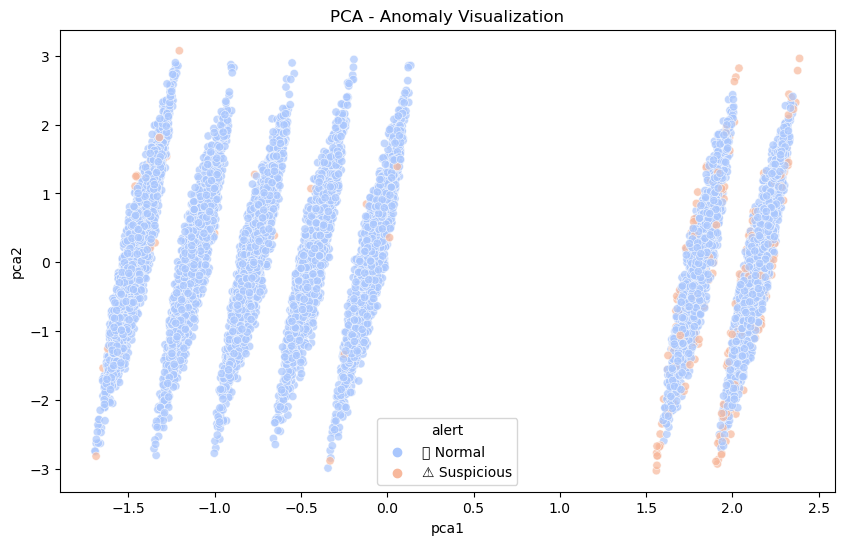

In [38]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['pca1'] = df_pca[:, 0]
df['pca2'] = df_pca[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='alert', palette='coolwarm', alpha=0.7)
plt.title('PCA - Anomaly Visualization')
plt.show()

## 14. Summary and Conclusion

The models successfully identified suspicious applications with unusual behaviors such as:
- Multiple rapid submissions
- Low resume quality
- Repeat attempts from same IP or email

Anomaly detection using both Isolation Forest and K-Means offered a comprehensive approach to uncover fraud patterns.